In [1]:
# pip install the required packages if running in Colab
try:
    import google.colab
    IN_COLAB = True
    %pip install summerepi2==1.0.4
    %pip install estival==0.1.7
except:
    IN_COLAB = False

In [2]:
# Standard imports, plotting option and constant definition
from datetime import datetime, timedelta
from typing import List, Union
import pandas as pd
import plotly.express as px
import numpy as np
import pickle

from jax import numpy as jnp

from summer2.utils import ref_times_to_dti

from summer2 import CompartmentalModel, Stratification, StrainStratification, Overwrite
from summer2.parameters import Parameter, Function, DerivedOutput, Time, Data

pd.options.plotting.backend = "plotly"
COVID_BASE_DATE = datetime(2019, 12, 31)


In [3]:
# Get a function to access the Malaysia data if running in Colab
if IN_COLAB:
    !wget https://raw.githubusercontent.com/monash-emu/AuTuMN/master/notebooks/capacity_building/malaysia/get_mys_data.py
    import get_mys_data
else:
    from notebooks.capacity_building.malaysia import get_mys_data 

# ... and use it to get the actual data
df = get_mys_data.fetch_mys_data()
initial_population = get_mys_data.get_initial_population("Malaysia")
observations = get_mys_data.get_target_observations(df, "Malaysia", "cases")
incidence_target = observations["cases_new"]
incidence_target.name = "incidence"
incidence_target_trimmed = incidence_target.loc["jul 2021": "nov 2021"]
start_date = datetime(2021, 3, 10)
end_date = start_date + timedelta(days=500)
start_date_int = (start_date - COVID_BASE_DATE).days
end_date_int = (end_date - COVID_BASE_DATE).days

# Model


In [4]:
unstratified_compartments = ["S", "I1", "I2", "R"]

In [5]:
def build_unstratified_model() -> CompartmentalModel:
    """
    Create a compartmental model, with compartmental structure needed to run and produce some sort of 
    meaningful outputs.
    
    Args:
        parameters: Flow parameters
    Returns:
        A compartmental model currently without stratification applied
    """
    model = CompartmentalModel(
        times=(start_date_int, end_date_int),
        compartments=unstratified_compartments,
        infectious_compartments=["I1", "I2"],
        ref_date=COVID_BASE_DATE
    )

    infectious_seed = Parameter("infectious_seed")
    infectious_period = Parameter("infectious_period")

    model.set_initial_population(
        distribution=
        {
            "S": initial_population - infectious_seed, 
            "I1": infectious_seed,
        }
    )
    
    # Susceptible people can get infected
    model.add_infection_frequency_flow(
        name="infection", 
        contact_rate=Parameter("beta"), 
        source="S",
        dest="I1",
    )  

    # People transition through the different infection stages
    model.add_transition_flow(
        name="progression",
        fractional_rate=2. / infectious_period,
        source="I1",
        dest="I2",
    )

    # Infectious people recover after some time spent infectious
    model.add_transition_flow(
        name="recovery",
        fractional_rate=2. / infectious_period,
        source="I2",
        dest="R",
    )
    
    # Only a proportion of new cases are identified as cases
    model.request_output_for_flow(
        name="incidence",
        flow_name="infection",
    )

    return model

In [11]:
def get_infectiousness_stratification() -> Stratification:
    """
    Create a summer stratification object that stratifies all of the infectious compartments into
    strata, which are intended to represent different levels of infectiousness.

    Returns:
        A summer stratification object to represent age stratification (not yet applied)
    """   
    # Some preparation
    strata = ["subspreader", "superspreader"]
    infectious_comps = ["I1", "I2"]

    # Create the stratification, just naming the age groups by their starting value
    strat = Stratification(
        name="infectiousness", 
        strata=strata, 
        compartments=infectious_comps
    )  
    
    # split between the different spredear categories (c := prop of superspreader)
    c = Parameter("c")
    split_props = {
        "subspreader": 1 - c,
        "superspreader": c
    }
    strat.set_flow_adjustments(
        "infection",
        split_props
    )

    rho = Parameter("rho")
    # adjust the infectiousness level of the different categories
    infectiousness_adjustments = {
        "subspreader": rho,
        "superspreader": 1.
    }        
    for infectious_comp in infectious_comps:
        strat.add_infectiousness_adjustments(
            infectious_comp,
            adjustments=infectiousness_adjustments
        )

    return strat



In [12]:
def build_full_model():

    # Get an unstratified model object
    model = build_unstratified_model()
    
    base_compartments = model.compartments

    # Get and apply the infectiousness stratification
    infectiousness_strat = get_infectiousness_stratification()
    model.stratify_with(infectiousness_strat)
    
    return model

# Example run

In [13]:
model = build_full_model()

In [14]:
model.get_input_parameters()

{'beta', 'c', 'infectious_period', 'infectious_seed', 'rho'}

In [78]:
parameters = {    
    'beta': .2, 
    'infectious_period': 7., 
    'infectious_seed': 100.,
        
    # spreader categories
    'c': .75,
    'rho': .5
}


In [82]:
model.run(parameters)
incidence_target = model.get_derived_outputs_df()["incidence"] 
incidence_target.plot()

## Automatic calibration

In [17]:
from estival import priors, targets
from estival.calibration.mcmc.adaptive import AdaptiveChain

In [85]:
def run_calibration(iterations):
    # define calibration targets
    mcmc_targets = [
        targets.NormalTarget("incidence", incidence_target, 10.) 
    ]

    # define priors
    mcmc_priors = [
        priors.UniformPrior("beta", [0.1, 0.5]),
        priors.UniformPrior("infectious_seed", [ 1., 1000]),
        priors.UniformPrior("c", [0., 1.]),
        priors.UniformPrior("rho", [0., 1.]),
    ]         

    # define initial parameters
    parameters = {
        'beta': .25, 
        'infectious_period': 7., 
        'infectious_seed': 500.,
        'c': .5,
        'rho': .5
    }
    init_p = parameters.copy()

    mcmc = AdaptiveChain(build_full_model, parameters, mcmc_priors, mcmc_targets, init_p)
    mcmc.run(max_iter=iterations)

    return mcmc

In [98]:
n_iterations = 10000
mcmc = run_calibration(n_iterations)

INFO:estival.calibration.mcmc.adaptive:Chain 0: running iteration 0, run 0
INFO:estival.calibration.mcmc.adaptive:Pre-adaptive phase completed at 50 iterations after 50 runs with an acceptance ratio of 0.2.
INFO:estival.calibration.mcmc.adaptive:Acceptance ratio acceptable, continue sampling.
INFO:estival.calibration.mcmc.adaptive:Chain 0: running iteration 1000, run 1000
INFO:estival.calibration.mcmc.adaptive:Chain 0: running iteration 2000, run 2000
INFO:estival.calibration.mcmc.adaptive:Chain 0: running iteration 3000, run 3000
INFO:estival.calibration.mcmc.adaptive:Chain 0: running iteration 4000, run 4000
INFO:estival.calibration.mcmc.adaptive:Chain 0: running iteration 5000, run 5000
INFO:estival.calibration.mcmc.adaptive:Chain 0: running iteration 6000, run 6000
INFO:estival.calibration.mcmc.adaptive:Chain 0: running iteration 7000, run 7000
INFO:estival.calibration.mcmc.adaptive:Chain 0: running iteration 8000, run 8000
INFO:estival.calibration.mcmc.adaptive:Chain 0: running it

In [99]:
import arviz as az
import random

In [100]:
# Some values to adjust to produce the desired outputs
burn_in_prop = 0.5
sample_for_plot = 2

In [101]:
burn_in = round(burn_in_prop * n_iterations)  # Find the integer number of burn-in iterations

burnt_results = mcmc.results[burn_in:]  # Get the MCMC results after burn-in
accepted_mcmc = [burnt_results[i] for i in range(len(burnt_results)) if burnt_results[i].accept]  # Extract the accepted iterations


In [102]:
accepted_mcmc

[]

In [103]:
mcmc_sample = random.sample(accepted_mcmc, sample_for_plot)  # Choose a sample to run for plotting later

inf_data = mcmc.to_arviz(burn_in)  # Get the post-burn in chain in arviz format

ValueError: Sample larger than population or is negative

In [ ]:
out_df = {}
recovered_df = {}
for i, r in enumerate(mcmc_sample):
    cur_params = parameters.copy()
    cur_params.update(r.parameters)
    model.run(cur_params)
    derived_out = model.get_derived_outputs_df()
    out_df[i] = derived_out["incidence"]


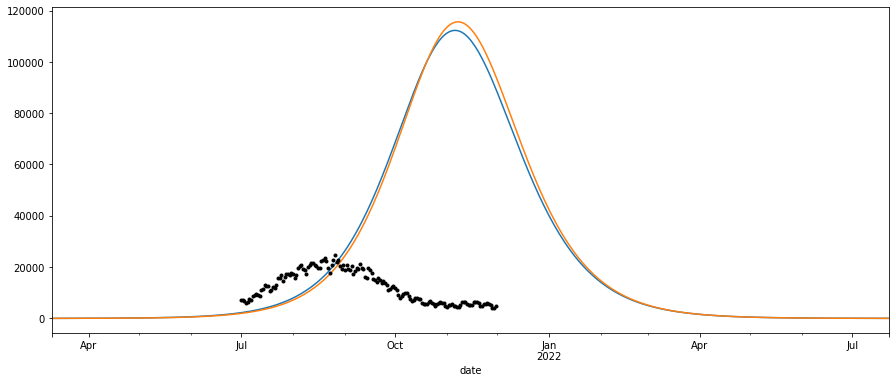

In [ ]:
pd.options.plotting.backend = "matplotlib"
ax = pd.DataFrame(out_df).plot(style='-', figsize=(15, 6), legend=False)
incidence_target_trimmed.plot(style='.', color="black")
pd.options.plotting.backend = "plotly"

In [ ]:
# Find the parameter set with the highest log likelihood obtained

best_ll = -np.inf
best_res = None

for r in mcmc.results:
    if r.ll > best_ll:
        best_ll = r.ll
        best_res = r
        
best_res.parameters

{'beta': 0.2582717200642618,
 'infectious_seed': 10187.97873376051,
 'c': 0.2746144235485741,
 'rho': 0.4314253755155088}

In [ ]:
max_ll_params = parameters.copy()
max_ll_params.update(best_res.parameters)

model.run(max_ll_params)

comparison_df = pd.DataFrame({
    "modelled": model.get_derived_outputs_df()["incidence"],
    "reported": incidence_target_trimmed,
})
comparison_df.plot()

In [ ]:
az.summary(inf_data)

Shape validation failed: input_shape: (1, 446), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta,0.256,0.003,0.250,0.258,0.003,0.002,3.0,6.0,NaN
infectious_seed,10189.303,2.262,10187.979,10194.954,1.563,1.311,3.0,1.0,NaN
c,0.283,0.011,0.275,0.300,0.009,0.008,3.0,1.0,NaN
rho,0.433,0.003,0.431,0.438,0.002,0.002,3.0,1.0,NaN


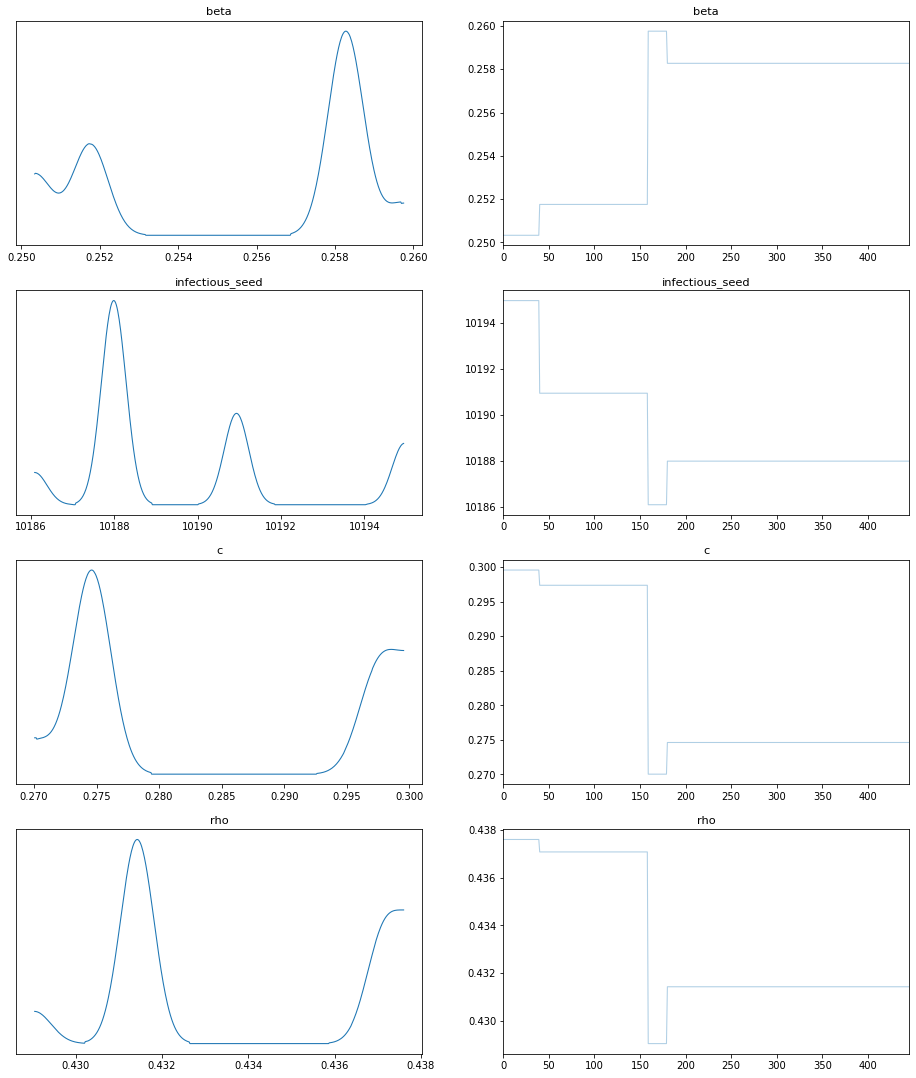

In [ ]:
az.plot_trace(inf_data, figsize=(16, 19));

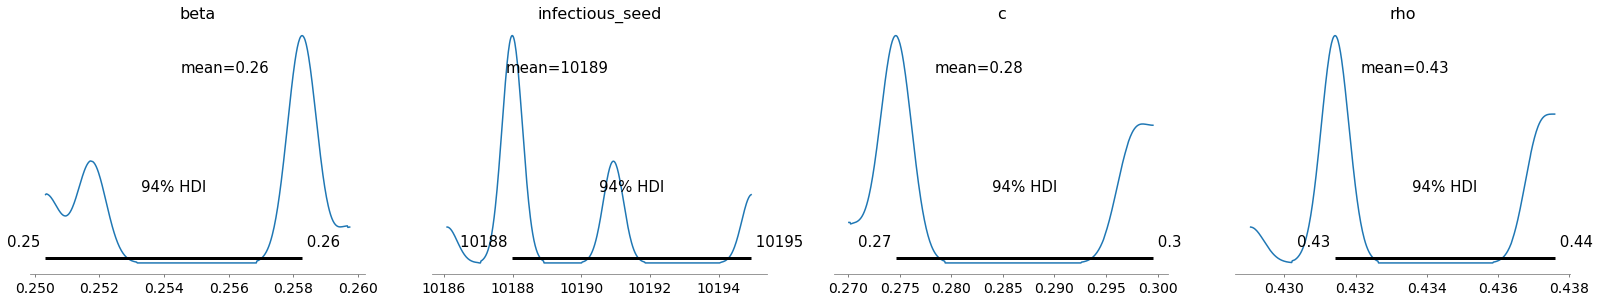

In [ ]:
az.plot_posterior(inf_data);

In [ ]:
from estival.utils import to_df, to_arviz

In [ ]:
caldf = to_df(mcmc)

In [ ]:
px.line(caldf, x="iteration", y="log_likelihood")

In [ ]:
from concurrent.futures import ThreadPoolExecutor
from functools import partial

def run_chain(chain_idx, n_iter, rand_init=False):
    init_p = parameters.copy()
    if rand_init:
        for p in mcmc_priors:
            init_p[p.name] = p.rv.rvs(1)[0]
    
    mcmc = AdaptiveChain(build_full_model, parameters, mcmc_priors, mcmc_targets, init_p,{"config": config},chain_id=chain_idx)
    mcmc.run(max_iter=n_iter)
    return mcmc



In [ ]:
n_chains = 4

run_func = partial(run_chain, rand_init=False,n_iter=2000)

with ThreadPoolExecutor(n_chains) as p:
    results = p.map(run_func,range(n_chains))

multichain_results = list(results)

In [ ]:
def get_chained_var(mcdf, variable):
    var_table = mcdf.pivot_table(index=["chain","iteration"])[variable]

    return pd.DataFrame(
        {c: var_table.loc[c] for c in mcdf["chain"].unique()}
    )

In [ ]:
mcdf = to_df(multichain_results, full_trace=True)
get_chained_var(mcdf, "log_likelihood").plot()

In [ ]:
# Burnin matters - the convergence statistics can often be improved by discarding more data...
inf_multichain = to_arviz(multichain_results, burnin=500)
az.summary(inf_multichain)

In [ ]:
az.plot_trace(inf_multichain, compact=False, legend=True, trace_kwargs={"alpha": 0.9}, figsize=(16, 19));

In [ ]:
az.plot_posterior(inf_multichain);

In [ ]:
px.scatter_matrix(mcdf, dimensions=[p.name for p in mcmc.priors], color="log_posterior", height=1000)

In [ ]:
px.scatter(mcdf, x="infectious_seed", y="log_posterior", color="chain")

In [ ]:
def resume_chain(mcmc, max_iter):
    mcmc.run(max_iter=max_iter)
    return mcmc

resume_func = partial(resume_chain,max_iter=2000)

with ThreadPoolExecutor(n_chains) as p:
    results = p.map(resume_func,multichain_results)

multichain_results = list(results)

In [ ]:
mcdf = to_df(multichain_results, full_trace=True)
get_chained_var(mcdf, "log_likelihood").plot()

In [ ]:
mcdf = to_df(multichain_results, burnin=1500)

In [ ]:
px.scatter_matrix(mcdf, dimensions=[p.name for p in mcmc.priors], color="log_posterior", height=1000)

In [ ]:
px.scatter(mcdf, x="beta", y="log_posterior", color="chain")

In [ ]:
inf_multichain = to_arviz(multichain_results, burnin=1500)
az.summary(inf_multichain)

In [ ]:
az.plot_trace(inf_multichain, compact=False, legend=True, trace_kwargs={"alpha": 0.9}, figsize=(16, 19));